# Model preparation

In [29]:
%%capture
!pip install torch==2.3.1
!pip install datasets

In [32]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes

In [37]:
# if any new packages are added, push to requirements.txt to freeze the version numbers
!pip freeze > requirements.txt

In [35]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Character limit length
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2024-07-28 02:24:06.005950: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-28 02:24:37.826791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-28 02:24:52.013731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Transformers is only compatible with Keras 2, but you have explicitly set `TF_USE_LEGACY_KERAS` to `0`. This may result in unexpected behaviour or errors if Keras 3 objects are passed to Transformers models.


==((====))==  Unsloth: Fast Llama patching release 2024.8
   \\   /|    GPU: Tesla T4. Max memory: 14.581 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

In [55]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [9]:
# check inference with some random prompt
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "How many minutes do you estimate this user story to take. Just give the number as output. No explanation needed.", # instruction
        "As a user, I wish to login to the system using a two factor authenticator securely, so that I can access its features.", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nHow many minutes do you estimate this user story to take. Just give the number as output. No explanation needed.\n\n### Input:\nAs a user, I wish to login to the system using a two factor authenticator securely, so that I can access its features.\n\n### Response:\n12\n```\n``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ``` ```']

<a name="Data"></a>
# Data Prep


**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

In [42]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [43]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass



In [12]:
# !wget https://huggingface.co/datasets/udaykiran19491/user-stories-from-tawos-for-llm-fine-tuning/resolve/main/stories.json

In [44]:
import json
from datasets import Dataset

def load_json_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data  # This will be a list of dictionaries

# Load the dataset
data = load_json_file('./stories.json')

# Convert to Hugging Face dataset
dataset = Dataset.from_list(data)

# Now you can apply your formatting function
dataset = dataset.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/22459 [00:00<?, ? examples/s]

In [45]:
# check dataset shape
dataset.shape

(22459, 4)

In [46]:
type(dataset)

datasets.arrow_dataset.Dataset

In [47]:
# check sample
dataset[0]

{'instruction': 'give resolution time in minutes for the given user story, only provide the number of minutes in the output without any other text',
 'input': '"As a developer, I\'d like to move k8s SPI to it\'s own repo."',
 'output': '11833.0',
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\ngive resolution time in minutes for the given user story, only provide the number of minutes in the output without any other text\n\n### Input:\n"As a developer, I\'d like to move k8s SPI to it\'s own repo."\n\n### Response:\n11833.0<|eot_id|>'}

In [48]:
data_list = [item for item in dataset]

In [18]:
import subprocess
def get_gpu_usage():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.free', '--format=csv,nounits,noheader'], 
                            stdout=subprocess.PIPE, text=True)
    used, free = result.stdout.strip().split('\n')[0].split(',')
    return int(used), int(free)

In [19]:
# Get and print GPU usage
used, free = get_gpu_usage()
print(f"GPU Memory Used: {used} MB, Free: {free} MB")

GPU Memory Used: 6199 MB, Free: 8731 MB


In [20]:
import gc
gc.collect()

55

In [21]:
torch.cuda.empty_cache()

In [22]:
# Get and print GPU usage
used, free = get_gpu_usage()
print(f"GPU Memory Used: {used} MB, Free: {free} MB")

GPU Memory Used: 6023 MB, Free: 8907 MB


# Zero Shot Prompting

In [27]:
import re
import json
from tqdm import tqdm
import torch

def process_dataset(dataset, model, tokenizer, output_file):
    # Create a progress bar
    progress_bar = tqdm(total=len(dataset), desc="Processing dataset", position=0, leave=True)
    
    for i in range(len(dataset) - 1, -1, -1):  # Iterate backwards
        try:
            item = dataset[i]
            inputs = tokenizer(
                [
                    alpaca_prompt.format(
                        item['instruction'], # instruction
                        item['input'], # input
                        "", # output - leave this blank for generation!
                    ) + EOS_TOKEN
                ], return_tensors="pt").to("cuda")
            
            with torch.no_grad():  # Disable gradient calculation
                outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)
            
            decoded_output = tokenizer.batch_decode(outputs)
            # Extract the numeric output
            match = re.search(r'### Response:.*?(\d+)', decoded_output[0], re.DOTALL)
            extracted_output = match.group(1) if match else "No numeric output found"
            
            result = {
                'instruction': item['instruction'],
                'input': item['input'],
                'true_output': item['output'],
                'model_output': extracted_output,
            }
            
            # Append the result to the output file
            with open(output_file, 'a') as f:
                json.dump(result, f)
                f.write('\n')
            
            # Remove the processed item from the dataset
            del dataset[i]
            
            # Update the progress bar
            progress_bar.update(1)
            
        except Exception as e:
            print(f"Error processing item {i}: {str(e)}")
            continue
        
        finally:
            # Clean up CUDA memory
            if 'inputs' in locals():
                del inputs
            if 'outputs' in locals():
                del outputs
            torch.cuda.empty_cache()
    
    # Close the progress bar
    progress_bar.close()

In [29]:
# get zero shot prompt results
process_dataset(data_list, model, tokenizer, "zero_shot_prompt_results.jsonl")

Processing dataset:  39%|███▊      | 8661/22420 [1:25:33<5:32:50,  1.45s/it] Unsloth: Input IDs of length 30065 > the model's max sequence length of 8192.
We shall truncate it ourselves. It's imperative if you correct this issue first.


Error processing item 13758: The size of tensor a (8192) must match the size of tensor b (30065) at non-singleton dimension 1


Processing dataset: 100%|█████████▉| 22419/22420 [3:43:01<00:00,  1.68it/s]  


In [2]:
import json
import pandas as pd

# Read the JSONL file
with open('zero_shot_prompt_results.jsonl', 'r') as file:
    data = [json.loads(line) for line in file]

# Convert to a pandas DataFrame
df = pd.DataFrame(data)

In [3]:
# Display the first few rows
print(df.head())

                                         instruction  \
0  give resolution time in minutes for the given ...   
1  give resolution time in minutes for the given ...   
2  give resolution time in minutes for the given ...   
3  give resolution time in minutes for the given ...   
4  give resolution time in minutes for the given ...   

                                               input true_output model_output  
0  "Update UI to match the mock up.(need provided...     95940.0           15  
1  "SPIKE - need to ensure that country names tha...     91879.0           30  
2  "Developers who want to build extensions for t...     34068.0           15  
3  "When a developer wishes to add another file t...     32148.0            5  
4  "The Edit Control tab allows the developer to ...     32073.0           15  


In [4]:
df.shape

(22419, 4)

In [8]:
# Drop any rows with non-numeric values
df = df.dropna(subset=['true_output', 'model_output'])

In [9]:
# Ensure 'true_output' and 'model_output' are numeric
df['true_output'] = pd.to_numeric(df['true_output'], errors='coerce')
df['model_output'] = pd.to_numeric(df['model_output'], errors='coerce')

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to both columns
df_clean = remove_outliers(df, 'true_output')
df_clean = remove_outliers(df_clean, 'model_output')

print(f"Original dataset size: {len(df)}")
print(f"Dataset size after outlier removal: {len(df_clean)}")

Original dataset size: 22342
Dataset size after outlier removal: 18846


In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mse = mean_squared_error(df_clean['true_output'], df_clean['model_output'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_clean['true_output'], df_clean['model_output'])
r2 = r2_score(df_clean['true_output'], df_clean['model_output'])

In [21]:
# Print results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")

Mean Squared Error (MSE): 10444714358.9626
Root Mean Squared Error (RMSE): 102199.3853
Mean Absolute Error (MAE): 60943.7276
R-squared (R²) Score: -0.5518


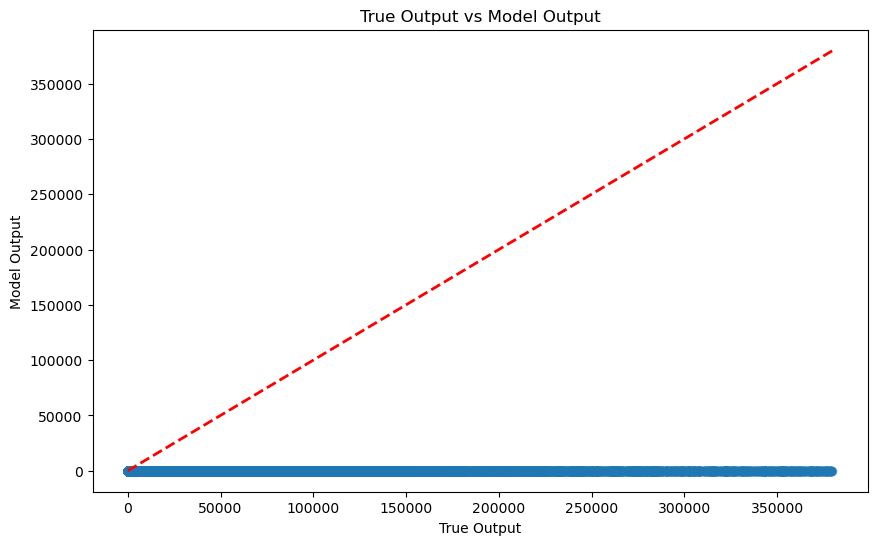

In [22]:
#Create a scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_clean['true_output'], df_clean['model_output'], alpha=0.5)
plt.plot([df_clean['true_output'].min(), df_clean['true_output'].max()], 
         [df_clean['true_output'].min(), df_clean['true_output'].max()], 
         'r--', lw=2)
plt.xlabel('True Output')
plt.ylabel('Model Output')
plt.title('True Output vs Model Output')
plt.show()

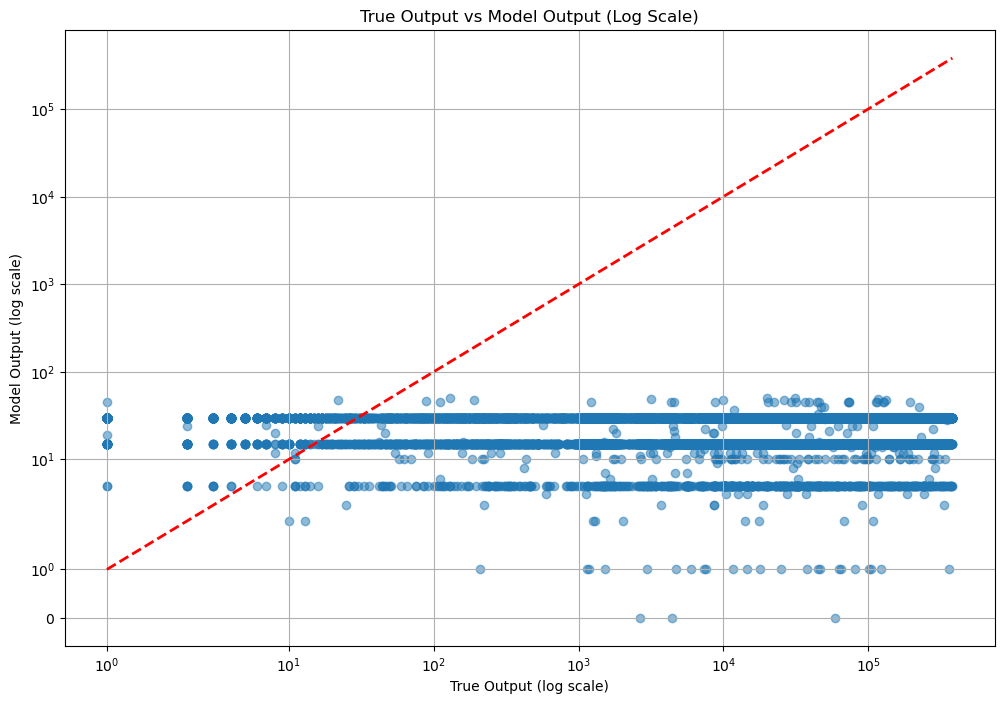

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))
plt.scatter(df_clean['true_output'], df_clean['model_output'], alpha=0.5)
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('True Output (log scale)')
plt.ylabel('Model Output (log scale)')
plt.title('True Output vs Model Output (Log Scale)')
plt.plot([df_clean['true_output'].min(), df_clean['true_output'].max()], 
         [df_clean['true_output'].min(), df_clean['true_output'].max()], 
         'r--', lw=2)
plt.grid(True)
plt.show()

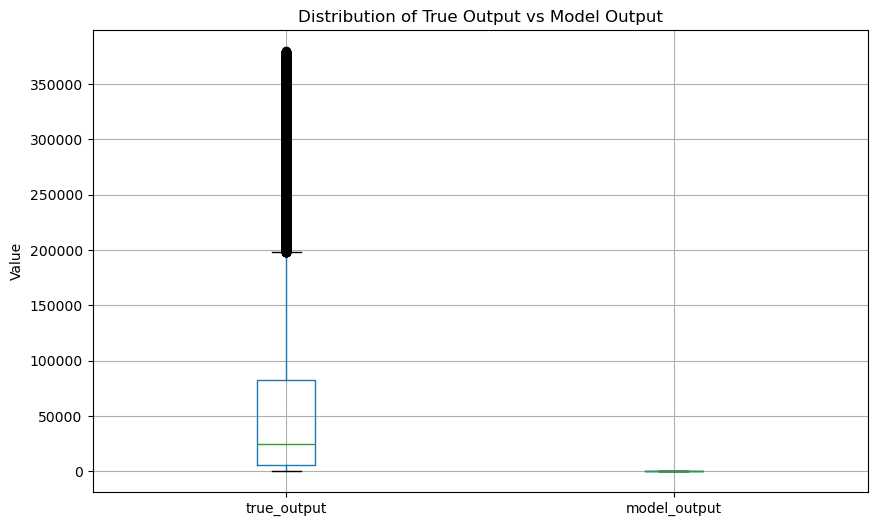

In [24]:
plt.figure(figsize=(10, 6))
df_clean.boxplot(column=['true_output', 'model_output'])
plt.title('Distribution of True Output vs Model Output')
plt.ylabel('Value')
plt.show()

# Fine Tuning

In [49]:
import random

def split_dataset(dataset, train_ratio=0.8, random_seed=42):
    # Set random seed for reproducibility
    random.seed(random_seed)

    # Get the total number of samples
    total_samples = len(dataset)

    # Calculate the number of samples for training
    train_samples = int(total_samples * train_ratio)

    # Create a list of indices and shuffle it
    indices = list(range(total_samples))
    random.shuffle(indices)

    # Split the indices
    train_indices = indices[:train_samples]
    test_indices = indices[train_samples:]

    # Create the train and test datasets
    train_dataset = dataset.select(train_indices)
    test_dataset = dataset.select(test_indices)

    return train_dataset, test_dataset

In [50]:
# get train and test data:
train_data, test_data = split_dataset(dataset)

In [52]:
train_data.shape

(17967, 4)

In [53]:
test_data.shape

(4492, 4)

<a name="Train"></a>
## Train the model

In [56]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/22459 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [57]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.581 GB.
5.613 GB of memory reserved.


In [58]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 22,459 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,3.969400
2,4.208000
3,3.720700
4,3.691100
5,3.564600
6,2.988600
7,2.696300
8,2.468500
9,2.142800
10,2.171800


In [59]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

374.7134 seconds used for training.
6.25 minutes used for training.
Peak reserved memory = 9.652 GB.
Peak reserved memory for training = 4.039 GB.
Peak reserved memory % of max memory = 66.196 %.
Peak reserved memory for training % of max memory = 27.7 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).